# Lab 06 - Generative adversarial networks

## Introduction

In this laboratory we will implement what is called in the literature a Cycle GAN (https://arxiv.org/pdf/1703.10593.pdf). These are powerful models that can learn to translate images without having paired samples to learn from.

A Generative Adversarial Network can generate novel data that is similar to that found in the training set (comes from the same distribution). As you've seen in the lecture, classic models can take random noise as input and learn to generate such data. There are also models where, in addition to the random noise, the model can take another input which it is meant to translate. For instance, this paper https://arxiv.org/pdf/1611.07004.pdf showcases translating images containing outlines alone to fully fledged objects.

![](./edge_to_obj_.png)

In such cases, there are pairs of desired inputs and outputs. However, it is rarely the case that we can create or benefit from such well structured datasets. The general case consists in samples gathered separately from the two classes that we wish to translate. For instance you can have several images of horses, and several images of zebras with no way of pairing them.

![](./h2z.png)

A CycleGAN can learn to translate from one class to another given such a scenario.

## CycleGAN

A CycleGAN primarily consists in have two GAN models: one that translates from the first class to the second, and one that translates from the second class to the first. Lets name those classes X and Y.

There will be a generator that takes as input an image from the X class and outputs an image from the Y class, a discrimiator that has to distinguish real Y images from fake ones, a generator that translates from Y to X and a final distriminator that classifies real and fake X images.

In order to prevent the generators to output a single image from the opposite class regardless of the input there is an additional factor that the model has to optimize; the most important aspect of the architecture. The translations have to be cycle consistent. This means that if we take an X image and translate it into a Y image, and then translate it again into an X image, we should end up with the exact same image we started with. This is the fundamental ideea of this model.

![](./cycle.png)

Additionally, we will introduce another loss term. Given a X image, we what that the generator that translates from Y to X to exactly reproduce it (identity loss), similarly, the other way around.

## Implemenatation

With the help of your superviser you can implement a CycleGAN starting from this code skeleton. The example featured will be translating apples to oranges, this is so that a model trained for a few iterations can provide visually interesting results. The same model cand then be applied to the zebras to horses dataset, provided you train the model for a larger number of iterations, all you have to do is replace the 'apple2orange' dataset name to 'horse2zebra'. The script will load that dataset and train the model on it without any other changes required.

Firstly, importing all neccessary tools and loading the dataset.

In [3]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import time

C:\Users\alinc\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In addition to loading the dataset, we will also jitter and normalize the input in order to enhance our models performance.

In [4]:
def jitter(im, label):
    im = tf.image.resize(im, [286, 286])
    im = tf.image.random_crop(im, [256, 256, 3])
    im = tf.image.random_flip_left_right(im)

    return im, label

def normalize(im, label):
    return tf.cast(im, tf.float32) / 255.

dataset, metadata = tfds.load(
    'cycle_gan/apple2orange',
    with_info = True, as_supervised = True
)
train_x = dataset['trainA'].map(jitter).map(normalize).repeat().shuffle(1000).batch(1)
train_y = dataset['trainB'].map(jitter).map(normalize).repeat().shuffle(1000).batch(1)
test_x = dataset['testA'].map(normalize).batch(1)
test_y = dataset['testB'].map(normalize).batch(1)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                         | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|                                                                             | 0/74 [00:01<?, ? MiB/s]

Extraction completed...: 0 file [00:01, ? file/s]
Dl Size...:   1%|▉                                                                    | 1/74 [00:06<08:00,  6.58s/ MiB]

Extraction completed...: 0 file [00:06, ? file/s]
Dl Size...:   3%|█▊                                                                   | 2/74 [00:10<06:00,  5.00s/ MiB]

Extraction completed...: 0 file [00:10, ? file/s]
Dl Size...:   4%|██▊                                                                  | 3/74 [00:13<04:52,  4.12s/ MiB]

Extraction completed...: 0 file [00:13, ? file/s]
Dl Size...:   5%|███▋                                                               

Dl Size...:  72%|████████████████████████████████████████████████▋                   | 53/74 [01:09<00:11,  1.78 MiB/s]

Extraction completed...: 0 file [01:09, ? file/s]
Dl Size...:  73%|█████████████████████████████████████████████████▌                  | 54/74 [01:10<00:11,  1.74 MiB/s]

Extraction completed...: 0 file [01:10, ? file/s]
Dl Size...:  74%|██████████████████████████████████████████████████▌                 | 55/74 [01:10<00:11,  1.70 MiB/s]

Extraction completed...: 0 file [01:10, ? file/s]
Dl Size...:  76%|███████████████████████████████████████████████████▍                | 56/74 [01:11<00:10,  1.68 MiB/s]

Extraction completed...: 0 file [01:11, ? file/s]
Dl Size...:  77%|████████████████████████████████████████████████████▍               | 57/74 [01:11<00:09,  1.85 MiB/s]

Extraction completed...: 0 file [01:11, ? file/s]
Dl Size...:  78%|█████████████████████████████████████████████████████▎              | 58/74 [01:12<00:08,  1.78 MiB/s]

Extraction completed...:

Shuffling C:\Users\alinc\tensorflow_datasets\cycle_gan\apple2orange\2.0.0.incompleteDXT4ZW\cycle_gan-trainA.tfrecord*..
Generating splits...:  25%|██████████████▎                                          | 1/4 [00:12<00:38, 12.88s/ splits]
Generating trainB examples...: 0 examples [00:00, ? examples/s]
Generating trainB examples...: 8 examples [00:00, 71.43 examples/s]
Generating trainB examples...: 16 examples [00:00, 71.19 examples/s]
Generating trainB examples...: 24 examples [00:00, 72.27 examples/s]
Generating trainB examples...: 32 examples [00:00, 72.64 examples/s]
Generating trainB examples...: 41 examples [00:00, 77.14 examples/s]
Generating trainB examples...: 51 examples [00:00, 81.92 examples/s]
Generating trainB examples...: 61 examples [00:00, 86.40 examples/s]
Generating trainB examples...: 70 examples [00:00, 87.31 examples/s]
Generating trainB examples...: 79 examples [00:00, 84.76 examples/s]
Generating trainB examples...: 88 examples [00:01, 79.22 examples/s]
Generat

Dataset cycle_gan downloaded and prepared to C:\Users\alinc\tensorflow_datasets\cycle_gan\apple2orange\2.0.0. Subsequent calls will reuse this data.


Now, we will define our generator architecture. For this class we will use a simple U-Net generator. The ideea is to concatenate the convolutional features in the following manner.

![](./unet.jpg)

For instance, if your first layer has 32 filters, your last layer (excluding the final output) that will also have 32 layers, will be contatenated with the first one obtaining 64 channels as input for what follows. Another example suppose you have an architecture with the following number of filters: input -> 32 -> 64 -> 128 -> 64 -> 32 -> 3(final output). Then, the final 32-filter convolution output will have its output concatened with the output of the first 32-filter convolution, and the last 64-filter convolution will have its output concatenated with that of the first 64-filter convolution output. The reason for this is that the generators have to reconstruct pretty much the same visual structure they received as input so instead of having the task of memorizing the structure, we will simply give the the structure for it as it advances in its reconstruction.

Our final layer will have sigmoid activation in order to reconstruct the input.

In [ ]:
from tensorflow.keras import layers
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()

        # define a list of convolutional layers with
        # 64, 128, 256 and 512 filters respectively
        # relu activations, same padding and a kernel of size 3
 
        # define a 2x2 max pooling layer
      
        # define a list of transposed convolutions with
        # 256, 128 and 64 filters respectively
        # relu activations, same padding, a kernnel of size 3 and a stride of size 2
    
        
        # define a final deconvolution with 3 filters, kernel size 3, stride 2,
        # sigmoid activation, and same padding

    def call(self, input):
        # sequentially apply the convolutions and pooling layer
        # retain all max pooling outputs in a list
      
        # sequentially apply all deconvolutions (except for the output layer)
        # concatenate each output with its correspoding convolutional output
        
        
        #apply the final decovolution and return the output
        ->

For the discrminator, since its will not have a complicated architecture, it will suffice to define a function that returns a sequential layer.

In [ ]:
def new_discriminator():
    # return a sequential model with
    # 4 convolutions with max pooling with the same parameters as the ones in the generator
    # a dense layer with 128 units and relu activation
    # a final prediction fully connected layer with 1 unit and sigmoid activation
    ->

We will instantiate all models and define their individual optimizers

In [ ]:
gen_x_y = Generator()
gen_y_x = Generator()
disc_x = new_discriminator()
disc_y = new_discriminator()

opt_gen_x_y = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
opt_gen_y_x = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
opt_disc_x = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
opt_disc_y = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

The complex part comes next, defining the fit_iteration function. If you think it thoroughly, take it step by step and work with your supervisor, it should come naturally. As a special mention, whenever using gradient taping you should perform **all** (loss) computations within the context. Outside the context should only be gradient applications.

In [ ]:
@tf.function
def fit_iteration(real_x, real_y):
    with tf.GradientTape(persistent = True) as tape:
        # watch variables from all 4 models
        ->

        # compute all need model outputs
        
        # generators applied on the real images
        # generators applied on the fake images (cycling)
        # generators applied for reconstructions (i.e. gen_x_y(real_y)) for the identity loss
        ->

        # discriminators applied on fake and real images
        ->
        
        # compute discriminator losses. Use mean binary cross entropy
        ->

        # compute generator losses. Use mean binary_cross_entropy
        # remember that the generator should trick the distriminator into thinking that the fake samples are real
        # should be cycle consistent
        # and should reproduce the input image if it is from the class that it should generate
        ->


    # compute and apply all gradients
    ->

The rest of the implementation is standard, trains the model for a few iterations and plots a few transformations applied on test images.

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    gen_x_y = gen_x_y,
    gen_y_x = gen_y_x,
    disc_x = disc_x,
    disc_y = disc_y,
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt,
    checkpoint_path,
    max_to_keep = 1
)

In [ ]:
train_x = iter(train_x)
train_y = iter(train_y)
n_iterations = 500
for i in range(n_iterations):
    fit_iteration(
        next(train_x), next(train_y)
    )
    print(i / n_iterations, end = '\r')

Additionally, you can implement Instance Normalization (https://arxiv.org/pdf/1607.08022.pdf) and regularization techniques in your model in order to further enhance performances.

Even without those, provided the implementation has been successful, the following block should yield semi-realistc images, even after training for as few as 500 iterations with a batch size of 1. Try it out!

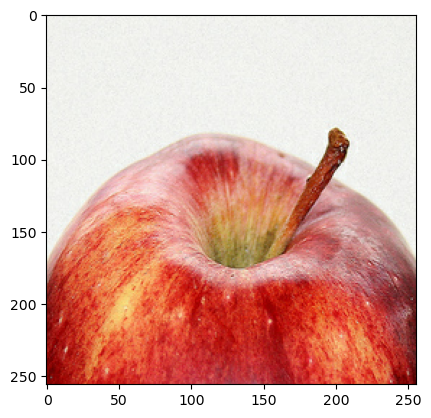

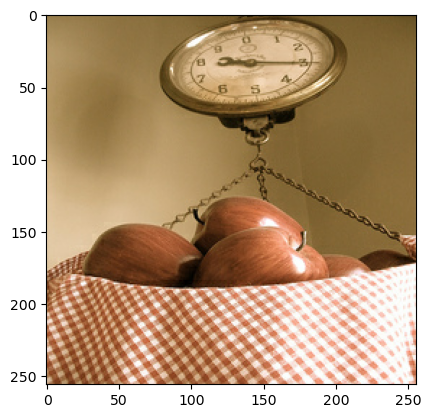

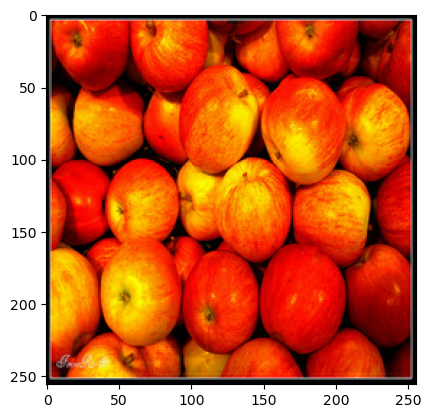

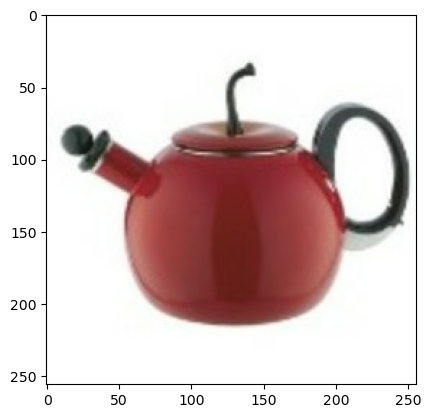

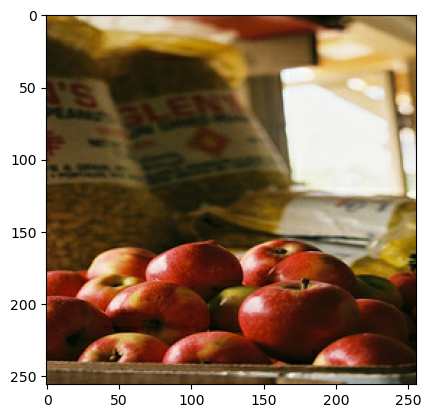

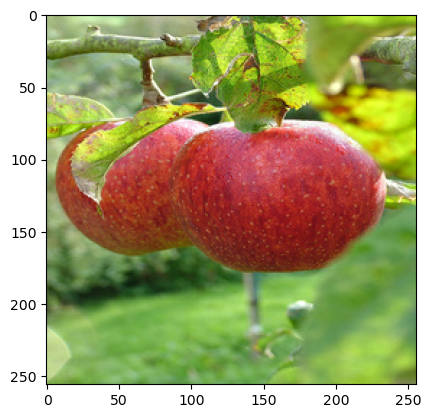

In [5]:
test_x = iter(test_x)
test_y = iter(test_y)
import matplotlib.pyplot as plt
for _ in range(6):
    real_x, real_y = next(test_x), next(test_y)
    plt.imshow(
        np.concatenate([
            real_x, gen_x_y(real_x)
        ], axis = 2)[0]
    )
    plt.show()